# Develop The Ice Coordinate System for SASSIE Play 1 Analysis

The goal of this analysis is to develop a robust, Cartesian coordinate system in which the transport of the SWIFT drifters can be transformed to the new coordinate system.

In [1]:
import cartopy
import cv2
import cmocean
import cftime
from datetime import datetime, timedelta
import numpy as np
import netCDF4 as nc
import pandas as pd
import pyproj as proj
import matplotlib.pyplot as plt
import matplotlib.colors
import metpy.calc as mpcalc
from scipy import io, interpolate, stats, signal

%matplotlib widget

In [2]:
# Helping Functions
def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    return datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)


In [3]:
# Load the dataframe
df = pd.read_csv('../data/play1_df.csv')
df = df[df['instrument_type'] == 'SWIFT']
df = df.dropna(subset=['hs'])
df.head()

Unnamed: 0.1  Unnamed: 0                        time   latitude  \
0             0           0  2022-09-09 21:24:00.000004  72.586037   
1             1           1  2022-09-09 21:36:00.000002  72.587006   
2             2           2  2022-09-09 21:48:00.000000  72.587936   
3             3           3  2022-09-09 21:59:59.999996  72.589012   
4             4           4  2022-09-09 22:12:00.000004  72.590172   

    longitude        hs  wave_direction  wave_direction_mathconv  drift_speed  \
0 -149.964966  0.815253       52.389679               217.610321          NaN   
1 -149.976730  0.939075       49.847000               220.153000     0.554840   
2 -149.988266  0.945042       80.848877               189.151123     0.554722   
3 -149.999924  0.934823      110.630768               159.369232     0.565919   
4 -150.011734  0.977387      104.254364               165.745636     0.581481   

   drift_direction  ... ice edge bearing  ice edge origin lon  \
0              NaN  ...       284.908258             -149.875   
1       285.247159  ...       284.908258             -149.875   
2       286.136217  ...       284.908258             -149.875   
3       287.676971  ...       284.908258             -149.875   
4       289.020320  ...       284.908258             -149.875   

   ice edge origin lat  along ice drift speed  cross ice drift speed  \
0            72.515909                    NaN                    NaN   
1            72.515909               0.554830               0.003282   
2            72.515909               0.554594               0.011888   
3            72.515909               0.565258               0.027336   
4            72.515909               0.579984               0.041697   

   along ice wind speed  cross ice wind speed  \
0             -4.039999              8.984963   
1             -4.897619              9.149994   
2             -5.630736              8.755097   
3             -4.791669              9.181570   
4             -4.984146              8.826921   

   along ice wind corrected drift speed  cross ice wind corrected drift speed  \
0                                   NaN                                   NaN   
1                              0.750735                             -0.362718   
2                              0.779824                             -0.338316   
3                              0.756925                             -0.339926   
4                              0.779350                             -0.311380   

   ice concentration  
0               70.0  
1               70.0  
2               70.0  
3               70.0  
4               70.0  

[5 rows x 32 columns]

In [ ]:
# Load the Gridded Ice Maps
ice_map_data = io.loadmat('../data/L1/nws_2022.mat')
ice_map_lat = ice_map_data['LAT']
ice_map_lon = ice_map_data['LON']
ice_map_conc = ice_map_data['iceconc'] * 10
ice_map_datenum = np.squeeze(ice_map_data['date'])
ice_map_date = [datenum_to_datetime(ice_map_datenum[n].astype(np.float64)) for n in range(ice_map_datenum.size)]

# Find index of closest Ice Map - September 10th 
ind_for_ice_map = 252
print(ice_map_date[ind_for_ice_map])
ice_concentration = ice_map_conc[:,:,ind_for_ice_map]

# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Plot locations of SWIFTs and Wavegliders
im = ax.scatter(df['longitude'], df['latitude'], c='m', s=1, transform=cartopy.crs.PlateCarree())

# Plot the ice map data
im = ax.pcolormesh(ice_map_lon, ice_map_lat, ice_concentration,
                   transform=cartopy.crs.PlateCarree(), cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im)
cbar.set_label('Ice Concentration [%]')
plt.tight_layout()

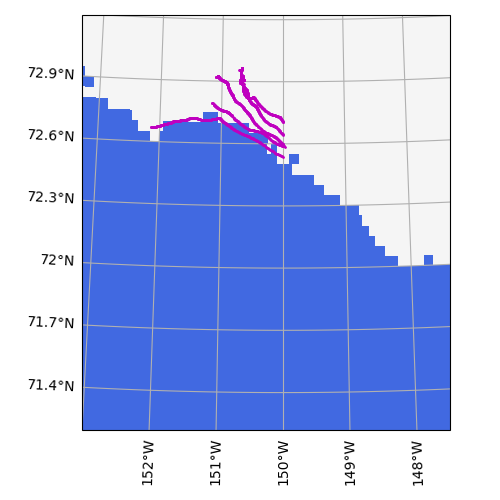

In [173]:
# Compute Ice Edge Based on 15% Concentration
ice_conc_15percent = np.zeros(ice_concentration.shape)
ice_conc_15percent[ice_concentration >= 15] = 1

# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# # Plot locations of SWIFTs and Wavegliders
im = ax.scatter(df['longitude'], df['latitude'], c='m', s=1, transform=cartopy.crs.PlateCarree())

# Plot the ice map data
cmap = matplotlib.colors.ListedColormap(['royalblue', 'whitesmoke'])
ax.pcolormesh(ice_map_lon, ice_map_lat, ice_conc_15percent,
                   transform=cartopy.crs.PlateCarree(), cmap=cmap, zorder=0)
plt.tight_layout()

Let's note here that the white is showing anywhere that the ice concentration is greater then 15% but it doesn't show exactly where the ice concentration is 15%.

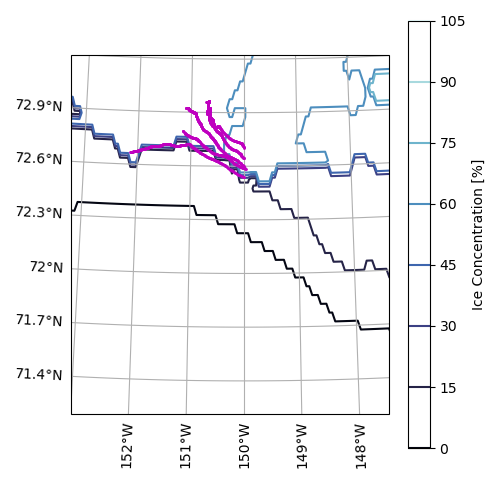

In [174]:
# Add Contour lines to the Ice Concentration Map 
fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Plot locations of SWIFTs and Wavegliders
im = ax.scatter(df['longitude'], df['latitude'], c='m', s=1, transform=cartopy.crs.PlateCarree())

# # Plot the ice map data
# im = ax.pcolormesh(ice_map_lon, ice_map_lat, ice_map_conc[:,:,ind_for_ice_map],
#                    transform=cartopy.crs.PlateCarree(), cmap=cmocean.cm.ice, zorder=0)
# cbar = fig.colorbar(im)
# cbar.set_label('Ice Concentration [%]')
contour = ax.contour(ice_map_lon, ice_map_lat, ice_concentration,
                     transform=cartopy.crs.PlateCarree(), cmap=cmocean.cm.ice, zorder=0)
ax.clabel(contour, levels=[0,  15,  30,  45,  60,  75,  90], inline=True, fontsize=10)
cbar = fig.colorbar(contour)
cbar.set_label('Ice Concentration [%]')
plt.tight_layout()

Here, we notice that there are steep gradients in the ice concentration in some areas but not in all areas. The gradient of ice concentration may be related to radiation stress gradients? 

Let's try to compute the ice concentration gradient and see of that looks.

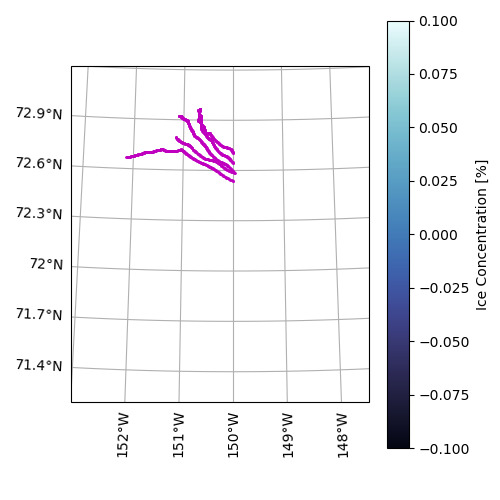

In [175]:
# Compute Ice concentration gradient
dx, dy = mpcalc.lat_lon_grid_deltas(ice_map_lat, ice_map_lon)
# ice_conc_gradient_x, ice_conc_gradient_y = mpcalc.gradient(ice_concentration, deltas=(dy, dx))
ice_conc_laplacian = mpcalc.geospatial_laplacian(ice_concentration, dx=dx, dy=dy)

# Plot Ice Concentration Gradient
fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Plot locations of SWIFTs and Wavegliders
im = ax.scatter(df['longitude'], df['latitude'], c='m', s=1, transform=cartopy.crs.PlateCarree())

# Plot the ice map data
im = ax.pcolormesh(ice_map_lon, ice_map_lat, ice_conc_laplacian,
                   transform=cartopy.crs.PlateCarree(), cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im)
cbar.set_label('Ice Concentration [%]')
# ax.contour(ice_map_lon, ice_map_lat, ice_concentration,
#             transform=cartopy.crs.PlateCarree(), cmap=cmocean.cm.ice, zorder=0)
plt.tight_layout()

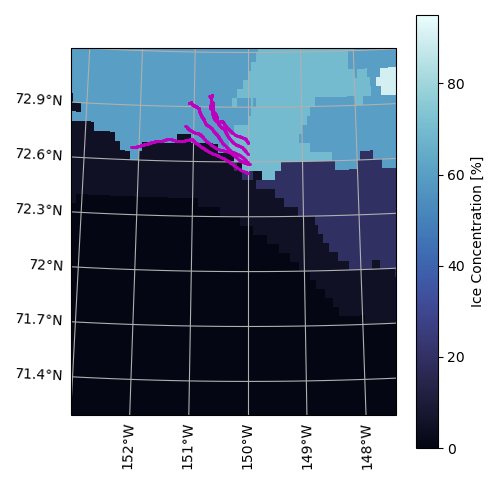

In [176]:
# Color the SWIFT Tracks by Salinity and Temperature
# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Plot locations of SWIFTs and Wavegliders
im = ax.scatter(df['longitude'], df['latitude'], c='m', s=1, transform=cartopy.crs.PlateCarree())

# Plot the ice map data
im = ax.pcolormesh(ice_map_lon, ice_map_lat, ice_concentration,
                   transform=cartopy.crs.PlateCarree(), cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im)
cbar.set_label('Ice Concentration [%]')
plt.tight_layout()

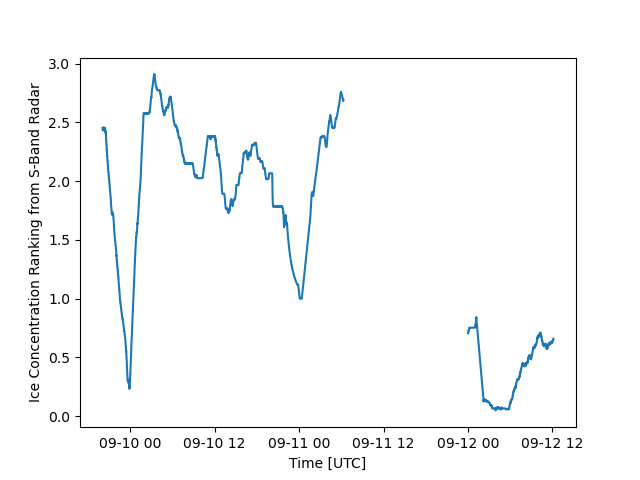

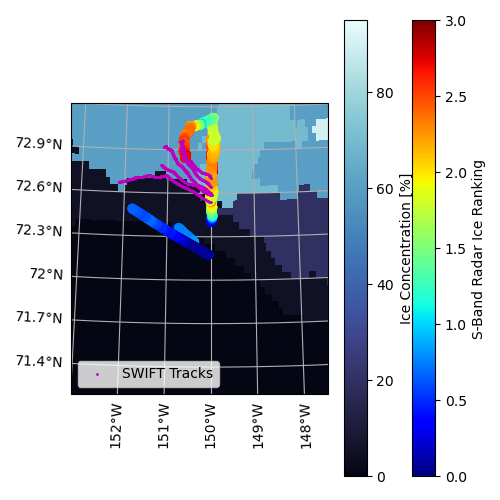

In [177]:
# Load the S-Band Radar Data from Ship and Plot over the Sea Ice Concentration products
sband_data = nc.Dataset('../data/SASSIE_FALL2022_SBAND_SUMMARY.nc')
sband_time = np.ma.filled(cftime.num2pydate(sband_data['time'],
                          units=sband_data['time'].units,
                          calendar='Gregorian'), np.NaN)
time_mask = (sband_time > datetime(2022, 9, 9, 19, 30, 0)) & (sband_time <= datetime(2022, 9, 12, 12, 10, 0))
sband_time = sband_time[time_mask]
sband_ice_ranking = sband_data['hourly_average_model_output_ranks'][time_mask]
sband_lat = sband_data['latitude'][time_mask]
sband_lon = sband_data['longitude'][time_mask]

# Plot Ice Ranking Time Series
fig, ax = plt.subplots()
ax.plot(sband_time, sband_ice_ranking)
ax.set_xlabel('Time [UTC]')
ax.set_ylabel('Ice Concentration Ranking from S-Band Radar')

# plot the Ice Concentration and the Ranking
# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Plot locations of SWIFTs and Wavegliders
im1 = ax.scatter(sband_lon, sband_lat, c=sband_ice_ranking, cmap='jet', clim=(0, 3), 
                 transform=cartopy.crs.PlateCarree())
cbar = fig.colorbar(im1)
cbar.set_label('S-Band Radar Ice Ranking')

# Plot the ice map data
im2 = ax.pcolormesh(ice_map_lon, ice_map_lat, ice_concentration,
                   transform=cartopy.crs.PlateCarree(), cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im2)
cbar.set_label('Ice Concentration [%]')
ax.scatter(df['longitude'], df['latitude'], c='m', s=1, transform=cartopy.crs.PlateCarree(), label='SWIFT Tracks')
ax.legend()
plt.tight_layout()

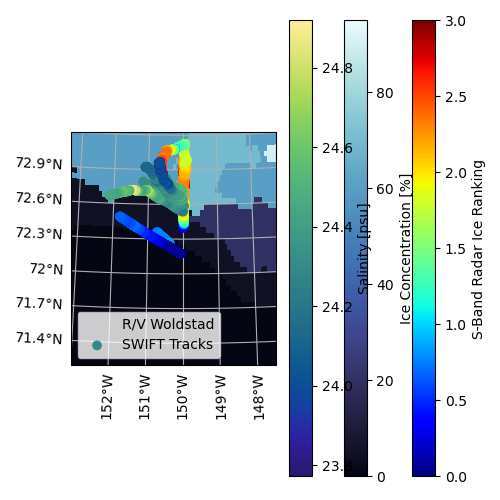

In [178]:

# plot the Ice Concentration and the Ranking
# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Plot locations of SWIFTs and Wavegliders
im1 = ax.scatter(sband_lon, sband_lat, c=sband_ice_ranking, cmap='jet', clim=(0, 3), 
                 transform=cartopy.crs.PlateCarree(), label='R/V Woldstad')
cbar = fig.colorbar(im1)
cbar.set_label('S-Band Radar Ice Ranking')

# Plot the ice map data
im2 = ax.pcolormesh(ice_map_lon, ice_map_lat, ice_concentration,
                   transform=cartopy.crs.PlateCarree(), cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im2)
cbar.set_label('Ice Concentration [%]')

im3 = ax.scatter(df['longitude'], df['latitude'], c=df['salinity'], cmap=cmocean.cm.haline, transform=cartopy.crs.PlateCarree(), label='SWIFT Tracks')
cbar = fig.colorbar(im3)
cbar.set_label('Salinity [psu]')
ax.legend()
plt.tight_layout()

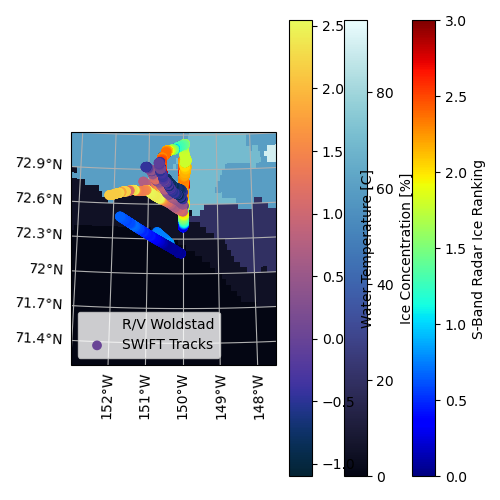

In [179]:

# plot the Ice Concentration and the Ranking
# Plot the ice map data
CRS = cartopy.crs.NorthPolarStereo(central_longitude=-150)
FIG_SIZE = (5,5)
EXTENT = [-153, -147.5, 71.2, 73.2]
OCEAN_COLOR = 'blue'

fig, ax = plt.subplots(subplot_kw=dict(projection=CRS), figsize=FIG_SIZE)
ax.set_extent(EXTENT)
ax.set_aspect('equal')
gridlines = ax.gridlines(draw_labels=True, dms=False,
                         x_inline=False, y_inline=False, zorder=0)
gridlines.top_labels = False
gridlines.left_labels = True
gridlines.right_labels = False

# Plot locations of SWIFTs and Wavegliders
im1 = ax.scatter(sband_lon, sband_lat, c=sband_ice_ranking, cmap='jet', clim=(0, 3), 
                 transform=cartopy.crs.PlateCarree(), label='R/V Woldstad')
cbar = fig.colorbar(im1)
cbar.set_label('S-Band Radar Ice Ranking')

# Plot the ice map data
im2 = ax.pcolormesh(ice_map_lon, ice_map_lat, ice_concentration,
                   transform=cartopy.crs.PlateCarree(), cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im2)
cbar.set_label('Ice Concentration [%]')

im3 = ax.scatter(df['longitude'], df['latitude'], c=df['water_temperature'], cmap=cmocean.cm.thermal, transform=cartopy.crs.PlateCarree(), label='SWIFT Tracks')
cbar = fig.colorbar(im3)
cbar.set_label('Water Temperature [C]')
ax.legend()
plt.tight_layout()

The goal now is to create a local parabolic coordinate system that is more representative of the ice edge. The steps to do this are to tranform the data to a local cartesian coordinate system and then transform the cartesian data onto a local parabolic coordinate system. 

In [180]:
def latlon_to_local(lat, lon, lat_0, lon_0):
    crs_wgs = proj.Proj(init='epsg:4326')  # assuming you're using WGS84 geographic

    #Erect own local flat cartesian coordinate system
    cust = proj.Proj("+proj=aeqd +lat_0={0} +lon_0={1} +datum=WGS84 +units=m".format(lat_0, lon_0))
    x, y = proj.transform(crs_wgs, cust, lon, lat)
    return x, y

def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)

    return r, theta


/opt/homebrew/Caskroom/mambaforge/base/envs/sassie-env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/2269121137.py:6: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = proj.transform(crs_wgs, cust, lon, lat)
/opt/homebrew/Caskroom/mambaforge/base/envs/sassie-env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://py

Text(0, 0.5, 'Y [m]')

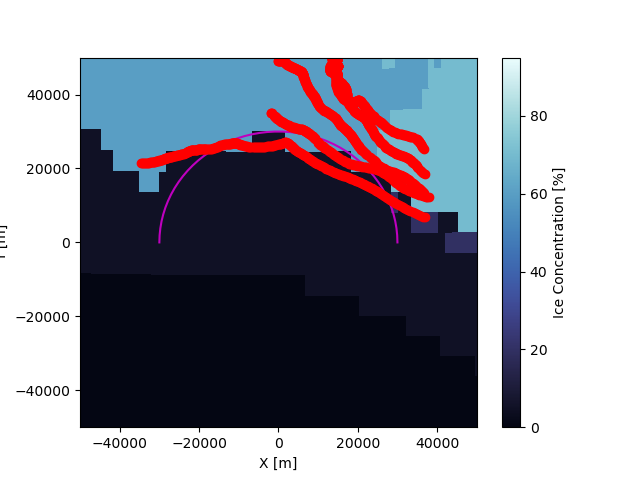

In [240]:
# Define the Local Cartesian Coordinate System
lat_0 = 72.48
lon_0 = -151.1

# Convert Lat lon on Ice Map to cartesian system 
x_icemap, y_icemap = latlon_to_local(ice_map_lat, ice_map_lon, lat_0, lon_0)

# Convert the SWIFT Track Coordinates to the local Cartesian system
x_swifts, y_swifts = latlon_to_local(df['latitude'], df['longitude'], lat_0, lon_0)

# Look at how a circle would fit this ice data
theta = np.linspace(0, np.pi)
r = 30000 # Approximate diameter from eyeing
x_circle = r * np.cos(theta)
y_circle = r * np.sin(theta)

# Plot the Cartesian System
fig, ax = plt.subplots()
ax.plot(x_circle, y_circle, color='m', zorder=1)
im2 = ax.pcolormesh(x_icemap, y_icemap, ice_concentration,
                    cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im2)
cbar.set_label('Ice Concentration [%]')
ax.scatter(x_swifts, y_swifts, color='r')
ax.set_xlim(-50000, 50000)
ax.set_ylim(-50000, 50000)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')


In [182]:
# Find the x and y location of the 15% ice concentration
# Find the 15% concentration contour line
ice_edge_contour_lon_vals = ice_map_lon[:,0]
lat_vals = ice_map_lat[0,:]

ice_edge_contour_lat_vals = []

for n in range(ice_conc_15percent.shape[0]):
    ice_edge_lat_index_array = np.where(ice_conc_15percent[n,:] == 1)[0]
    if ice_edge_lat_index_array.size > 0:
        ice_edge_contour_lat_vals.append(lat_vals[ice_edge_lat_index_array[0]])
    else:
        ice_edge_contour_lat_vals.append(np.NaN)

# Convert lon values to numpy array
ice_edge_contour_lat_vals = np.array(ice_edge_contour_lat_vals)
print(ice_edge_contour_lat_vals)
print(ice_edge_contour_lon_vals)

# Convert the ice edge values to cartesian and polar coordinates
x_iceedge, y_iceedge = latlon_to_local(ice_edge_contour_lat_vals, ice_edge_contour_lon_vals, lat_0, lon_0)
r_iceedge, theta_iceedge = cartesian_to_polar(x_iceedge, y_iceedge)

[   nan    nan    nan ... 71.875 71.875 71.875]
[-185.125 -185.075 -185.025 ... -135.225 -135.175 -135.125]


/opt/homebrew/Caskroom/mambaforge/base/envs/sassie-env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/2269121137.py:6: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = proj.transform(crs_wgs, cust, lon, lat)


(1001, 501)
(1001, 501)
(1001, 501)


/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/446899572.py:14: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p = ax.pcolormesh(theta_ice, r_ice, ice_concentration, cmap=cmocean.cm.ice, zorder=0)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/446899572.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  p = ax.pcolormesh(theta_ice, r_ice, ice_concentration, cmap=cmocean.cm.ice, zorder=0)


(0.0, 60000.0)

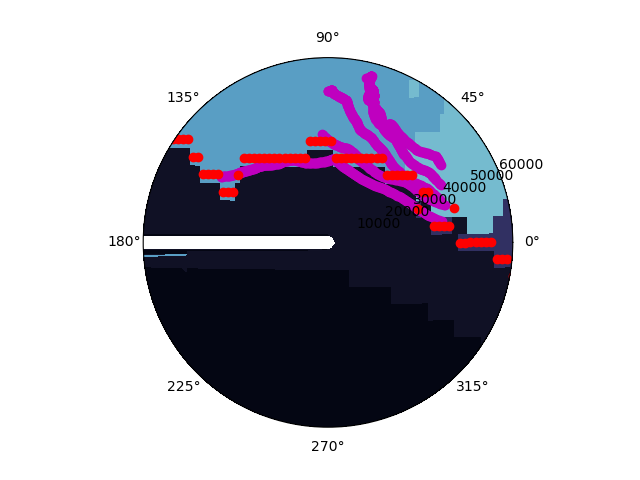

In [183]:
# Convert the Data to Polar Coordinates
r_ice, theta_ice = cartesian_to_polar(x_icemap, y_icemap)

# Convert SWIFT tracks to polar coordinates
r_swift, theta_swift = cartesian_to_polar(x_swifts, y_swifts)

print(r_ice.shape)
print(theta_ice.shape)
print(ice_concentration.shape)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(theta_swift, r_swift, color='m')
ax.scatter(theta_iceedge, r_iceedge, color='r')
p = ax.pcolormesh(theta_ice, r_ice, ice_concentration, cmap=cmocean.cm.ice, zorder=0)
ax.set_rlim(0, 60000)

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/3324589732.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p = ax.pcolormesh(theta_ice, r_ice, ice_concentration, cmap=cmocean.cm.ice, zorder=0)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/3324589732.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  p = ax.pcolormesh(theta_ice, r_ice, ice_concentration, cmap=cmocean.cm.ice, zorder=0)


(0.0, 60000.0)

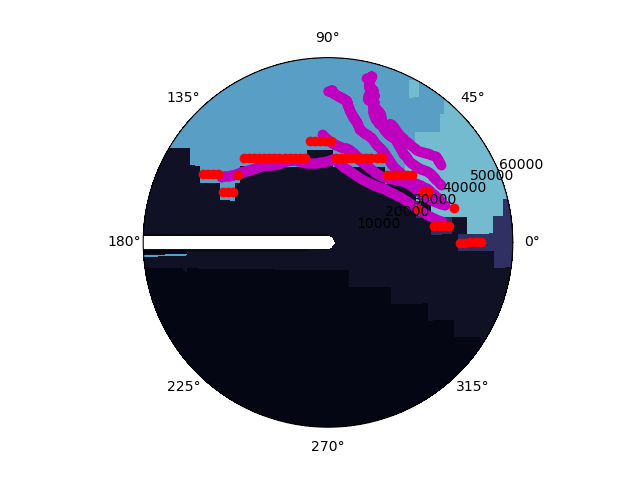

In [184]:
# Look at radial distribution of the ice edge
play1_radius_inds = r_iceedge < 5*(10**4)
r_iceedge_play1 = r_iceedge[play1_radius_inds]
theta_iceedge_play1 = theta_iceedge[play1_radius_inds]

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(theta_swift, r_swift, color='m')
ax.scatter(theta_iceedge_play1, r_iceedge_play1, color='r')
p = ax.pcolormesh(theta_ice, r_ice, ice_concentration, cmap=cmocean.cm.ice, zorder=0)
ax.set_rlim(0, 60000)


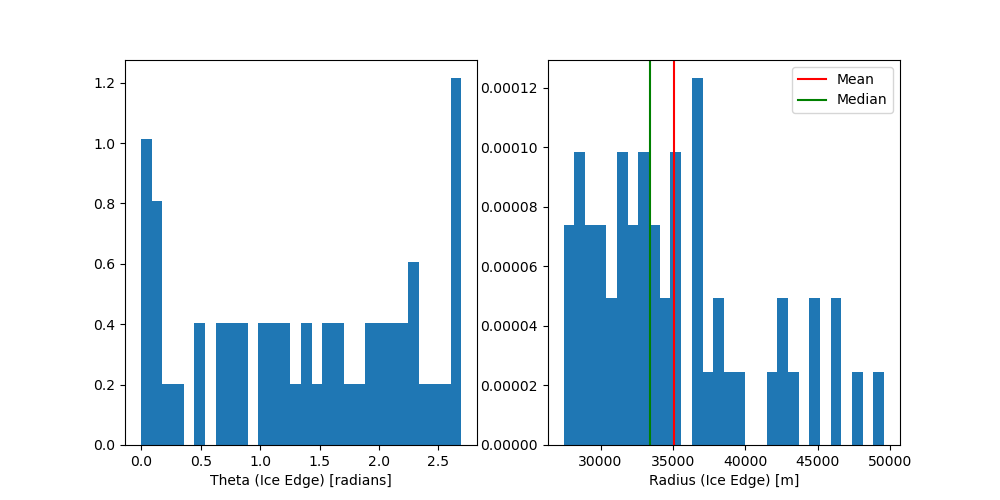

In [185]:
# Distribution of ice edge
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10,5))
ax1.hist(theta_iceedge_play1, bins=30, density=True)
ax1.set_xlabel('Theta (Ice Edge) [radians]')

ax2.hist(r_iceedge_play1, bins=30, density=True)
ax2.axvline(np.mean(r_iceedge_play1), color='r', label='Mean')
ax2.axvline(np.median(r_iceedge_play1), color='g', label='Median')
ax2.set_xlabel('Radius (Ice Edge) [m]')
ax2.legend()

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/3763788414.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  p = ax.pcolormesh(theta_ice, r_ice, ice_concentration, cmap=cmocean.cm.ice, zorder=0)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/3763788414.py:12: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  p = ax.pcolormesh(theta_ice, r_ice, ice_concentration, cmap=cmocean.cm.ice, zorder=0)


(0.0, 60000.0)

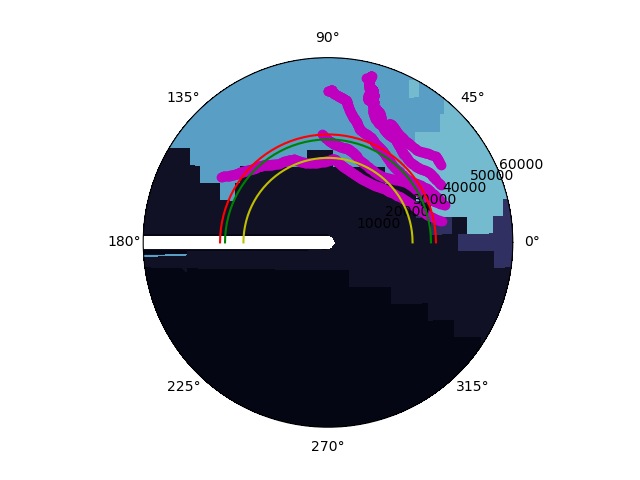

In [186]:
# Plot the Mean Radius of the ice edge
theta = np.linspace(0, np.pi)
mean_ice_radius = np.mean(r_iceedge_play1) * np.ones(theta.size)
median_ice_radius = np.median(r_iceedge_play1) * np.ones(theta.size)
min_ice_radius = np.min(r_iceedge_play1) * np.ones(theta.size)

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.scatter(theta_swift, r_swift, color='m')
ax.plot(theta, mean_ice_radius, color='r')
ax.plot(theta, median_ice_radius, color='g')
ax.plot(theta, min_ice_radius, color='y')
p = ax.pcolormesh(theta_ice, r_ice, ice_concentration, cmap=cmocean.cm.ice, zorder=0)
ax.set_rlim(0, 60000)

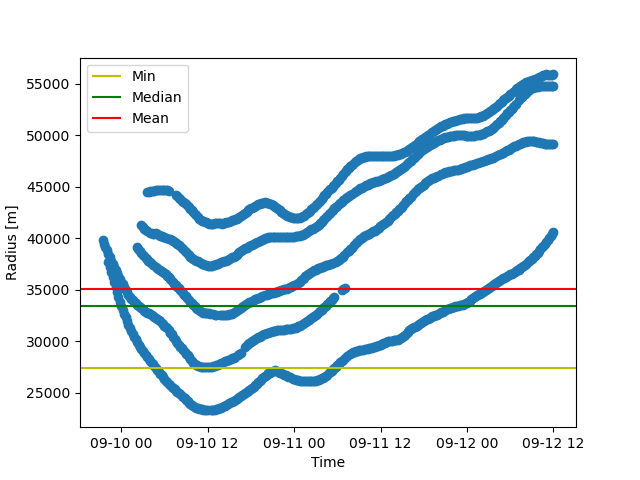

In [187]:
fig, ax = plt.subplots()
time = pd.to_datetime(df['time'])
ax.scatter(time, r_swift)
ax.axhline(min_ice_radius[0], color='y', label='Min')
ax.axhline(median_ice_radius[0], color='g' ,label='Median')
ax.axhline(mean_ice_radius[0], color='r', label='Mean')
ax.set_xlabel('Time')
ax.set_ylabel('Radius [m]')
ax.legend()

Text(0.5, 0, 'Time')

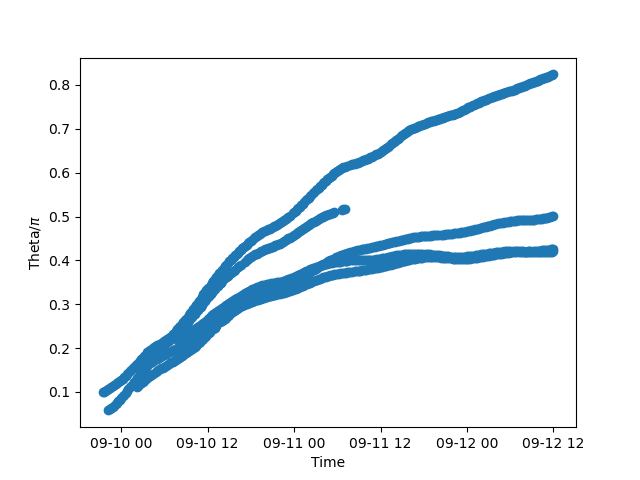

In [188]:
fig, ax = plt.subplots()
ax.scatter(time, theta_swift/np.pi)
ax.set_ylabel('Theta/$\pi$')
ax.set_xlabel('Time')

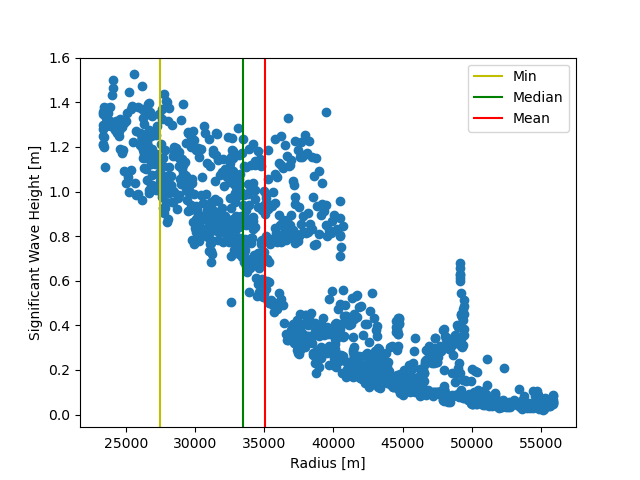

In [189]:
fig, ax = plt.subplots()
ax.scatter(r_swift, df['hs'])
ax.axvline(min_ice_radius[0], color='y', label='Min')
ax.axvline(median_ice_radius[0], color='g' ,label='Median')
ax.axvline(mean_ice_radius[0], color='r', label='Mean')
ax.set_xlabel('Radius [m]')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()

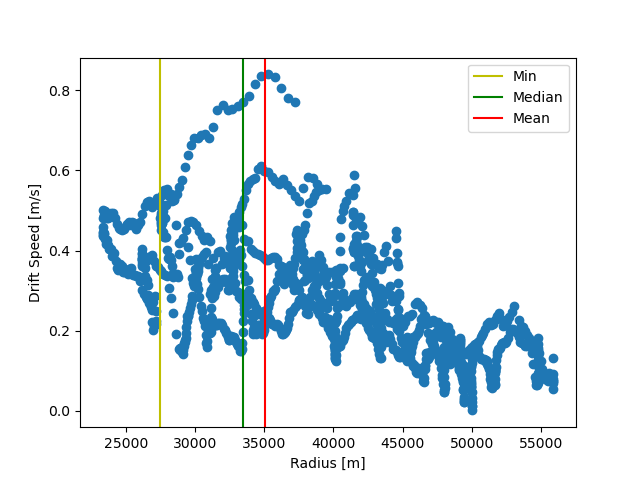

In [190]:
fig, ax = plt.subplots()
ax.scatter(r_swift, df['drift_speed'])
ax.axvline(min_ice_radius[0], color='y', label='Min')
ax.axvline(median_ice_radius[0], color='g' ,label='Median')
ax.axvline(mean_ice_radius[0], color='r', label='Mean')
ax.set_xlabel('Radius [m]')
ax.set_ylabel('Drift Speed [m/s]')
ax.legend()

0.00012250399920381804


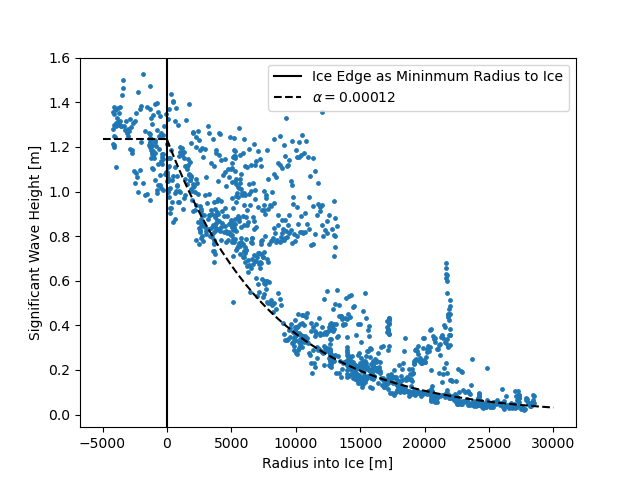

In [219]:
# Min Ice Edge Coefficient
openwater_inds = (r_swift - min_ice_radius[0]) < 0
ice_inds = (r_swift - min_ice_radius[0]) > 0
H0_ice_edge_min = np.nanmean(df['hs'].loc[openwater_inds])
regress_results = stats.linregress((r_swift[ice_inds] - min_ice_radius[0]), np.log(H0_ice_edge_min) - np.log(df['hs'].loc[ice_inds]))
alpha_ice_edge_min = regress_results.slope
print(alpha_ice_edge_min)

# # Median Ice Edge Coefficient
# openwater_inds = r_swift < median_ice_radius[0]
# H0_ice_edge_median = np.nanmean(df['hs'].loc[openwater_inds])
# regress_results = stats.linregress(r_swift[openwater_inds], np.log(H0_ice_edge_median) - np.log(df['hs'].loc[openwater_inds]))
# alpha_ice_edge_median = regress_results.slope

# # Mean Ice Edge Coefficient
# openwater_inds = r_swift < mean_ice_radius[0]
# H0_ice_edge_mean = np.nanmean(df['hs'].loc[openwater_inds])
# regress_results = stats.linregress(r_swift[openwater_inds], np.log(H0_ice_edge_mean) - np.log(df['hs'].loc[openwater_inds]))
# alpha_ice_edge_mean = regress_results.slope

fig, ax = plt.subplots()
ax.scatter(r_swift - min_ice_radius[0], df['hs'], s=6)
ax.axvline(0, color='k', label='Ice Edge as Mininmum Radius to Ice')
r_min_openocean = np.linspace(-5000, 0)
ax.plot(r_min_openocean, H0_ice_edge_min*np.ones(r_min_openocean.size), color='k', linestyle='dashed')
r_min_ice_vals = np.linspace(0, 30000)
ax.plot(r_min_ice_vals, H0_ice_edge_min * np.exp(-alpha_ice_edge_min*r_min_ice_vals), color='k', linestyle='dashed', label=fr'$ \alpha = {np.round(alpha_ice_edge_min, 5)} $')
ax.set_xlabel('Radius into Ice [m]')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()


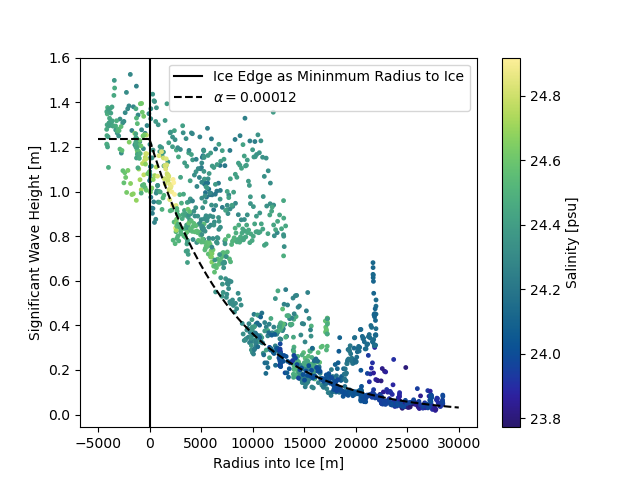

In [ ]:
fig, ax = plt.subplots()
im = ax.scatter(r_swift - min_ice_radius[0], df['hs'], s=6, c=df['salinity'], cmap=cmocean.cm.haline)
cbar = fig.colorbar(im)
cbar.set_label('Salinity [psu]')
ax.axvline(0, color='k', label='Ice Edge as Mininmum Radius to Ice')
r_min_openocean = np.linspace(-5000, 0)
ax.plot(r_min_openocean, H0_ice_edge_min*np.ones(r_min_openocean.size), color='k', linestyle='dashed')
r_min_ice_vals = np.linspace(0, 30000)
ax.plot(r_min_ice_vals, H0_ice_edge_min * np.exp(-alpha_ice_edge_min*r_min_ice_vals), color='k', linestyle='dashed', label=fr'$ \alpha = {np.round(alpha_ice_edge_min, 5)} $')
ax.set_xlabel('Radius into Ice [m]')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()

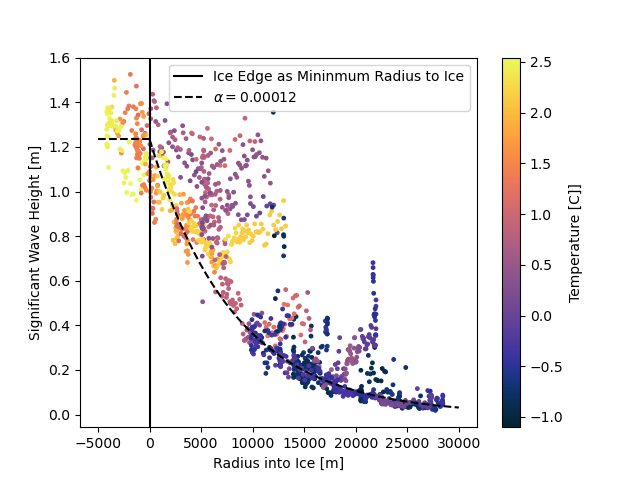

In [224]:
fig, ax = plt.subplots()
im = ax.scatter(r_swift - min_ice_radius[0], df['hs'], s=6, c=df['water_temperature'], cmap=cmocean.cm.thermal)
cbar = fig.colorbar(im)
cbar.set_label('Temperature [C]]')
ax.axvline(0, color='k', label='Ice Edge as Mininmum Radius to Ice')
r_min_openocean = np.linspace(-5000, 0)
ax.plot(r_min_openocean, H0_ice_edge_min*np.ones(r_min_openocean.size), color='k', linestyle='dashed')
r_min_ice_vals = np.linspace(0, 30000)
ax.plot(r_min_ice_vals, H0_ice_edge_min * np.exp(-alpha_ice_edge_min*r_min_ice_vals), color='k', linestyle='dashed', label=fr'$ \alpha = {np.round(alpha_ice_edge_min, 5)} $')
ax.set_xlabel('Radius into Ice [m]')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()

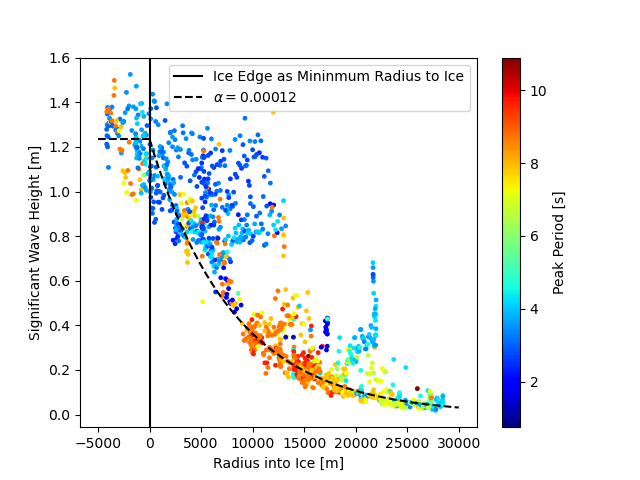

In [225]:
fig, ax = plt.subplots()
im = ax.scatter(r_swift - min_ice_radius[0], df['hs'], s=6, c=df['wave_period'], cmap='jet')
cbar = fig.colorbar(im)
cbar.set_label('Peak Period [s]')
ax.axvline(0, color='k', label='Ice Edge as Mininmum Radius to Ice')
r_min_openocean = np.linspace(-5000, 0)
ax.plot(r_min_openocean, H0_ice_edge_min*np.ones(r_min_openocean.size), color='k', linestyle='dashed')
r_min_ice_vals = np.linspace(0, 30000)
ax.plot(r_min_ice_vals, H0_ice_edge_min * np.exp(-alpha_ice_edge_min*r_min_ice_vals), color='k', linestyle='dashed', label=fr'$ \alpha = {np.round(alpha_ice_edge_min, 5)} $')
ax.set_xlabel('Radius into Ice [m]')
ax.set_ylabel('Significant Wave Height [m]')
ax.legend()

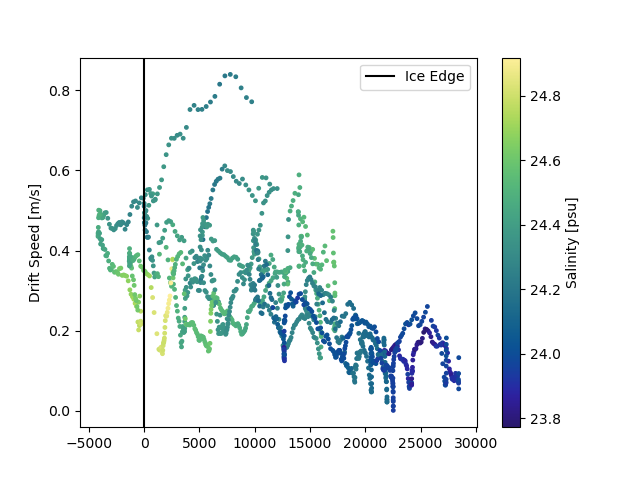

In [229]:
fig, ax = plt.subplots()
im = ax.scatter(r_swift - min_ice_radius[0], df['drift_speed'], s=6, c=df['salinity'], cmap=cmocean.cm.haline)
cbar = fig.colorbar(im)
cbar.set_label('Salinity [psu]')
ax.axvline(0, color='k', label='Ice Edge')
ax.set_ylabel('Drift Speed [m/s]')
ax.legend()

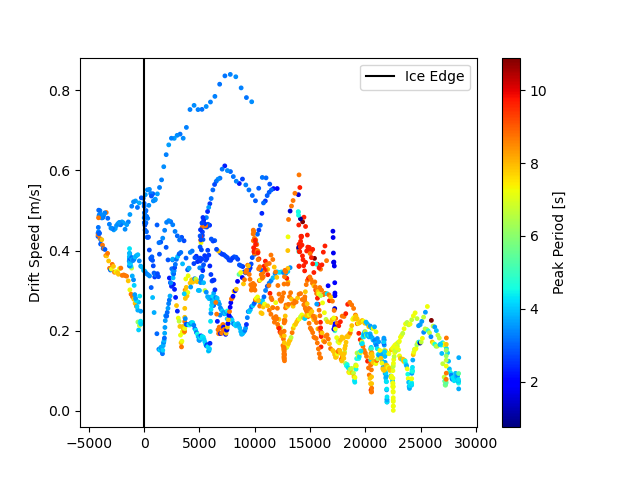

In [231]:
fig, ax = plt.subplots()
im = ax.scatter(r_swift - min_ice_radius[0], df['drift_speed'], s=6, c=df['wave_period'], cmap='jet')
cbar = fig.colorbar(im)
cbar.set_label('Peak Period [s]')
ax.axvline(0, color='k', label='Ice Edge')
ax.set_ylabel('Drift Speed [m/s]')
ax.legend()

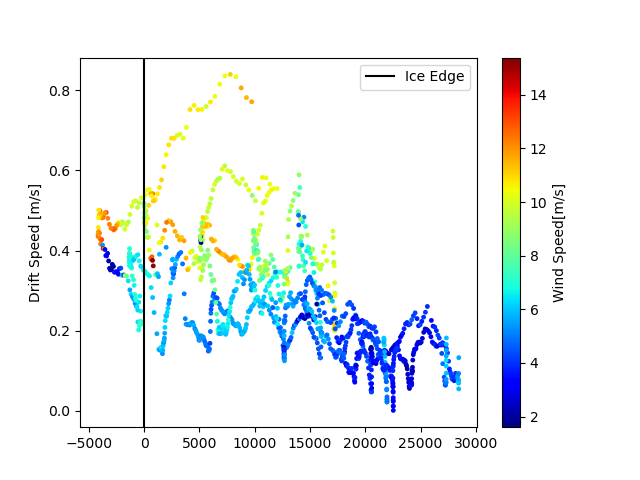

In [234]:
fig, ax = plt.subplots()
im = ax.scatter(r_swift - min_ice_radius[0], df['drift_speed'], s=6, c=df['windspd'], cmap='jet')
cbar = fig.colorbar(im)
cbar.set_label('Wind Speed [m/s]')
ax.axvline(0, color='k', label='Ice Edge')
ax.set_ylabel('Drift Speed [m/s]')
ax.legend()

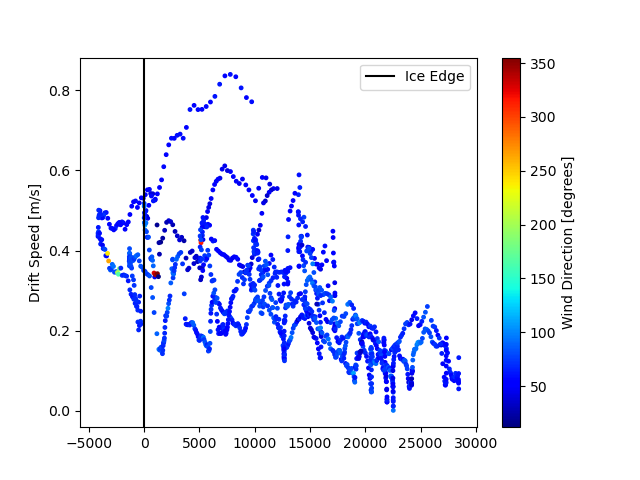

In [237]:
fig, ax = plt.subplots()
im = ax.scatter(r_swift - min_ice_radius[0], df['drift_speed'], s=6, c=df['winddir'], cmap='jet')
cbar = fig.colorbar(im)
cbar.set_label('Wind Direction [degrees]')
ax.axvline(0, color='k', label='Ice Edge')
ax.set_ylabel('Drift Speed [m/s]')
ax.legend()

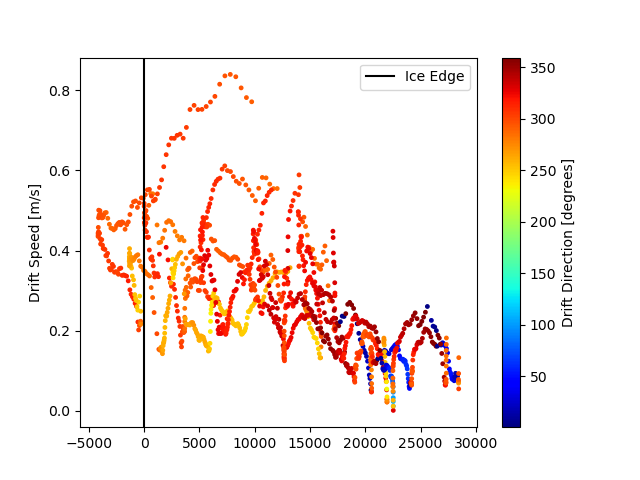

In [239]:
fig, ax = plt.subplots()
im = ax.scatter(r_swift - min_ice_radius[0], df['drift_speed'], s=6, c=df['drift_direction'], cmap='jet')
cbar = fig.colorbar(im)
cbar.set_label('Drift Direction [degrees]')
ax.axvline(0, color='k', label='Ice Edge')
ax.set_ylabel('Drift Speed [m/s]')
ax.legend()

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/1077827374.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax.pcolormesh(x_icemap, y_icemap, ice_concentration,


Text(0, 0.5, 'Y [m]')

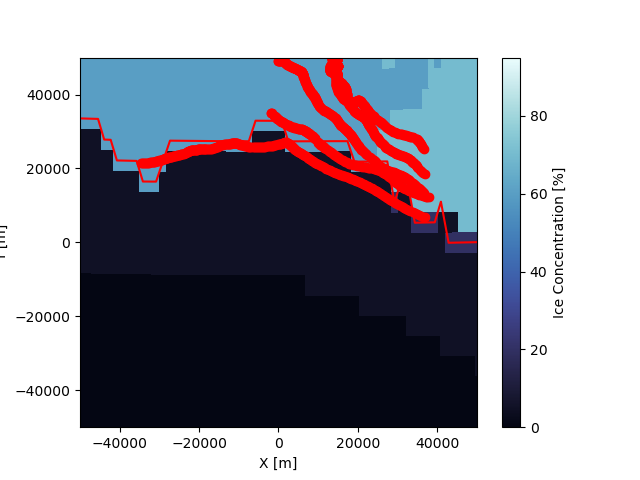

In [ ]:
# Interpolate the x and y ice edge values to make a smooth curve of the ice edge
x_iceedge_interp = np.linspace(-50000, 50000, num=50000)
y_iceedge_interp = np.interp(x_iceedge_interp, x_iceedge, y_iceedge)

# Plot the Cartesian System
fig, ax = plt.subplots()
ax.plot(x_iceedge_interp, y_iceedge_interp, color='m')
im2 = ax.pcolormesh(x_icemap, y_icemap, ice_concentration,
                    cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im2)
cbar.set_label('Ice Concentration [%]')
ax.scatter(x_swifts, y_swifts, color='r')
ax.set_xlim(-50000, 50000)
ax.set_ylim(-50000, 50000)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')


/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/1742637606.py:30: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax.pcolormesh(x_icemap, y_icemap, ice_concentration,


Text(0, 0.5, 'Y [m]')

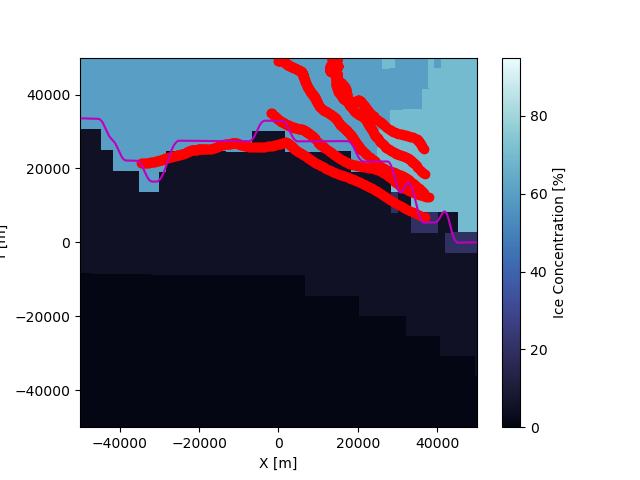

In [248]:
# Smooth the Interpolated Curve
def moving_average_smoothing(data, window_size):
    """
    Applies moving average smoothing to a list or numpy array.

    Args:
        data (list or np.array): The input data to smooth.
        window_size (int): The number of data points to include in the moving average window.

    Returns:
        np.array: The smoothed data as a numpy array.
    """
    if window_size > len(data):
        raise ValueError("Window size cannot be larger than the data length.")
    
    series = pd.Series(data)
    windows = series.rolling(window_size)
    moving_averages = windows.mean()
    smoothed_data = moving_averages.to_numpy()
    return smoothed_data

# Interpolate the x and y ice edge values to make a smooth curve of the ice edge
x_iceedge_interp = np.linspace(-60000, 60000, num=50000)
y_iceedge_interp = np.interp(x_iceedge_interp, x_iceedge, y_iceedge)
y_iceedge_smoothed = moving_average_smoothing(y_iceedge_interp, 1000)

# Plot the Cartesian System
fig, ax = plt.subplots()
ax.plot(x_iceedge_interp, y_iceedge_smoothed, color='m')
im2 = ax.pcolormesh(x_icemap, y_icemap, ice_concentration,
                    cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im2)
cbar.set_label('Ice Concentration [%]')
ax.scatter(x_swifts, y_swifts, color='r')
ax.set_xlim(-50000, 50000)
ax.set_ylim(-50000, 50000)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

The window mean is not very good at smoothing this, lets use a low pass butterworth filter to smooth instead

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/2417867849.py:17: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax.pcolormesh(x_icemap, y_icemap, ice_concentration,


Text(0, 0.5, 'Y [m]')

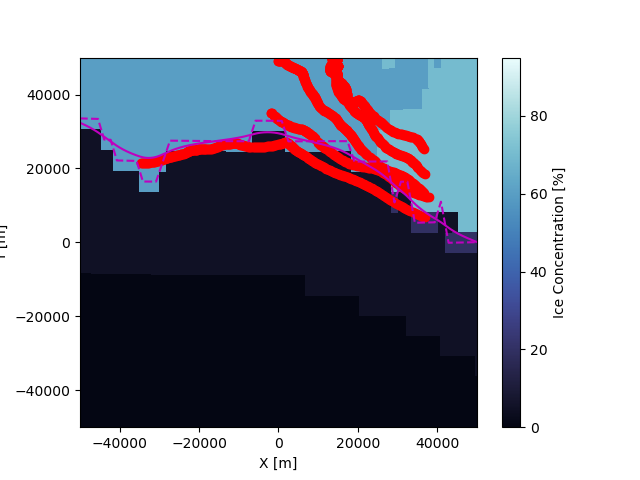

In [284]:
# Interpolate the x and y ice edge values to make a smooth curve of the ice edge
x_iceedge_interp = np.linspace(-60000, 60000, num=50000)
y_iceedge_interp = np.interp(x_iceedge_interp, x_iceedge, y_iceedge)

fs = 1 / (x_iceedge_interp[1] - x_iceedge_interp[0])
cutoff = 1/40000
order = 1
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
y_iceedge_smoothed = signal.filtfilt(b, a, y_iceedge_interp)

# Plot the Cartesian System
fig, ax = plt.subplots()
ax.plot(x_iceedge_interp, y_iceedge_interp, color='m', linestyle='dashed')
ax.plot(x_iceedge_interp, y_iceedge_smoothed, color='m')
im2 = ax.pcolormesh(x_icemap, y_icemap, ice_concentration,
                    cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im2)
cbar.set_label('Ice Concentration [%]')
ax.scatter(x_swifts, y_swifts, color='r')
ax.set_xlim(-50000, 50000)
ax.set_ylim(-50000, 50000)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

/opt/homebrew/Caskroom/mambaforge/base/envs/sassie-env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/2269121137.py:6: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = proj.transform(crs_wgs, cust, lon, lat)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/3528407122.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply exp

Text(0, 0.5, 'Y [m]')

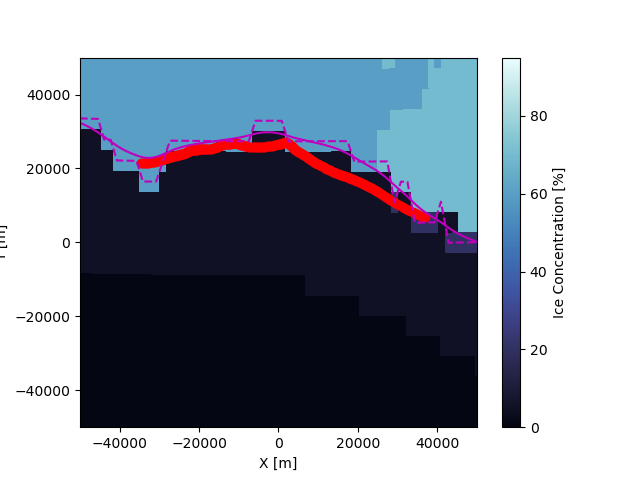

In [330]:
df_swift15 = df[df['swiftnum'] == 15]
x_swift15, y_swift15 = latlon_to_local(df_swift15['latitude'], df_swift15['longitude'], lat_0, lon_0)

# Plot the Cartesian System
fig, ax = plt.subplots()
ax.plot(x_iceedge_interp, y_iceedge_interp, color='m', linestyle='dashed')
ax.plot(x_iceedge_interp, y_iceedge_smoothed, color='m')
im2 = ax.pcolormesh(x_icemap, y_icemap, ice_concentration,
                    cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im2)
cbar.set_label('Ice Concentration [%]')
ax.scatter(x_swift15, y_swift15, color='r')
ax.set_xlim(-50000, 50000)
ax.set_ylim(-50000, 50000)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')


In [338]:
# Compute the Difference between each SWIFT point from the ice edge
def distance_to_ice_edge(x_ice_edge, y_ice_edge, x_object, y_object):
    distance_to_ice_edge_coordinate = np.empty(x_object.size)
    for i in range(x_object.size):
        distance_to_ice_edge_array = []
        for n in range(x_ice_edge.size):
            distance_to_ice_edge_array.append(np.sqrt((x_object[i] - x_ice_edge[n])**2 + (y_object[i] - y_ice_edge[n])**2))

        distance_to_ice_edge_coordinate[i] = np.min(distance_to_ice_edge_array) * np.sign(y_object[i] - y_ice_edge[np.argmin(distance_to_ice_edge_array)])
        

    return distance_to_ice_edge_coordinate

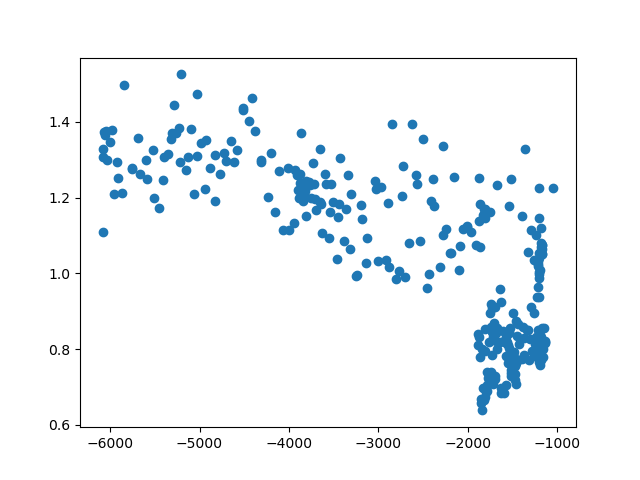

In [341]:
distance_to_ice_edge_coordinate_swift = distance_to_ice_edge(x_iceedge_interp, y_iceedge_smoothed, x_swift15, y_swift15)

# Plot Significant Wave Height in the New Ice Distance Coordinate System
fig, ax = plt.subplots()
ax.scatter(distance_to_ice_edge_coordinate_swift, df_swift15['hs'])

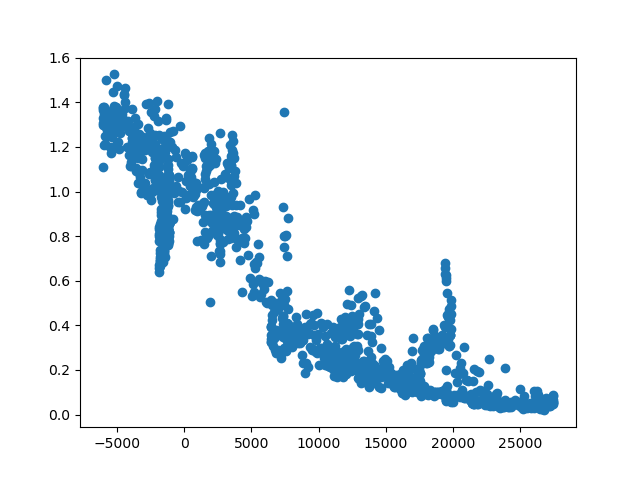

In [342]:
distance_to_ice_edge_coordinate_swifts = distance_to_ice_edge(x_iceedge_interp, y_iceedge_smoothed, x_swifts, y_swifts)


Text(0, 0.5, 'Significant Wave Height [m]')

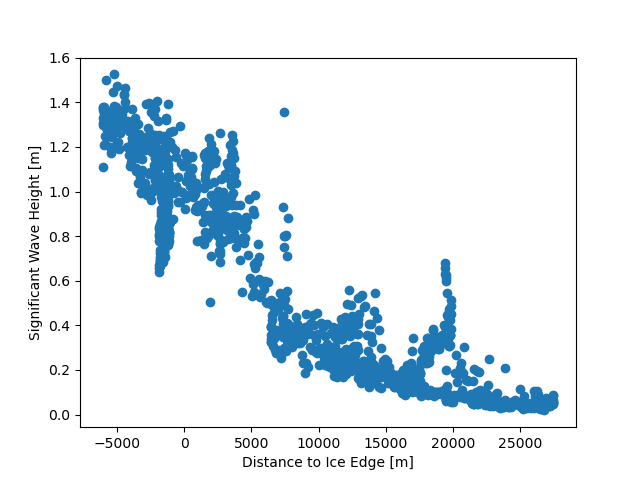

In [344]:
# Plot Significant Wave Height in the New Ice Distance Coordinate System
fig, ax = plt.subplots()
ax.scatter(distance_to_ice_edge_coordinate_swifts, df['hs'])
ax.set_xlabel('Distance to Ice Edge [m]')
ax.set_ylabel('Significant Wave Height [m]')

In [375]:
# Add the wave gliders back in
df_with_gliders = pd.read_csv('../data/play1_df.csv')
df_with_gliders = df_with_gliders.dropna(subset=['hs'])
df_with_gliders.head()

Unnamed: 0.1  Unnamed: 0                        time   latitude  \
0             0           0  2022-09-09 21:24:00.000004  72.586037   
1             1           1  2022-09-09 21:36:00.000002  72.587006   
2             2           2  2022-09-09 21:48:00.000000  72.587936   
3             3           3  2022-09-09 21:59:59.999996  72.589012   
4             4           4  2022-09-09 22:12:00.000004  72.590172   

    longitude        hs  wave_direction  wave_direction_mathconv  drift_speed  \
0 -149.964966  0.815253       52.389679               217.610321          NaN   
1 -149.976730  0.939075       49.847000               220.153000     0.554840   
2 -149.988266  0.945042       80.848877               189.151123     0.554722   
3 -149.999924  0.934823      110.630768               159.369232     0.565919   
4 -150.011734  0.977387      104.254364               165.745636     0.581481   

   drift_direction  ... ice edge bearing  ice edge origin lon  \
0              NaN  ...       284.908258             -149.875   
1       285.247159  ...       284.908258             -149.875   
2       286.136217  ...       284.908258             -149.875   
3       287.676971  ...       284.908258             -149.875   
4       289.020320  ...       284.908258             -149.875   

   ice edge origin lat  along ice drift speed  cross ice drift speed  \
0            72.515909                    NaN                    NaN   
1            72.515909               0.554830               0.003282   
2            72.515909               0.554594               0.011888   
3            72.515909               0.565258               0.027336   
4            72.515909               0.579984               0.041697   

   along ice wind speed  cross ice wind speed  \
0             -4.039999              8.984963   
1             -4.897619              9.149994   
2             -5.630736              8.755097   
3             -4.791669              9.181570   
4             -4.984146              8.826921   

   along ice wind corrected drift speed  cross ice wind corrected drift speed  \
0                                   NaN                                   NaN   
1                              0.750735                             -0.362718   
2                              0.779824                             -0.338316   
3                              0.756925                             -0.339926   
4                              0.779350                             -0.311380   

   ice concentration  
0               70.0  
1               70.0  
2               70.0  
3               70.0  
4               70.0  

[5 rows x 30 columns]

In [348]:
# Compute Distance to ice edge with all SWIFTs and Gliders
x_swifts_gliders, y_swifts_gliders = latlon_to_local(df_with_gliders['latitude'], df_with_gliders['longitude'], lat_0, lon_0)
distance_to_ice_edge_coordinate_swifts_gliders = distance_to_ice_edge(x_iceedge_interp, y_iceedge_smoothed, x_swifts_gliders, y_swifts_gliders)

/opt/homebrew/Caskroom/mambaforge/base/envs/sassie-env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/2269121137.py:6: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = proj.transform(crs_wgs, cust, lon, lat)


Text(0, 0.5, 'Significant Wave Height [m]')

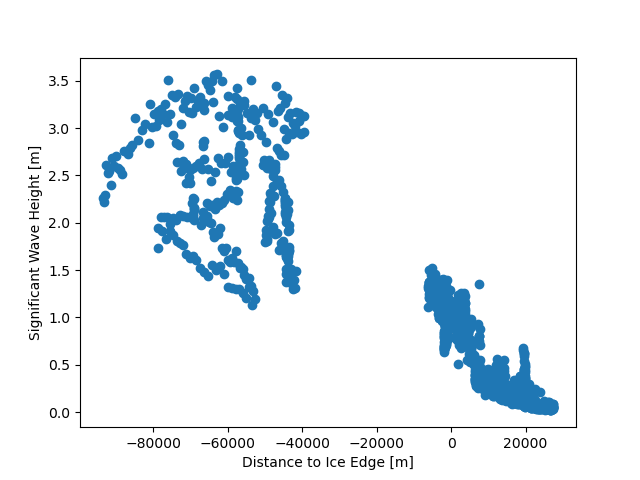

In [349]:
# Plot Significant Wave Height in the New Ice Distance Coordinate System
fig, ax = plt.subplots()
ax.scatter(distance_to_ice_edge_coordinate_swifts_gliders, df_with_gliders['hs'])
ax.set_xlabel('Distance to Ice Edge [m]')
ax.set_ylabel('Significant Wave Height [m]')

Well the scatter near the ice has been reduced but not out at the wave gliders. So we may need to further expand the ice edge estimate to expand that to the wave gliders.

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/2503011608.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im2 = ax.pcolormesh(x_icemap, y_icemap, ice_concentration,


Text(0, 0.5, 'Y [m]')

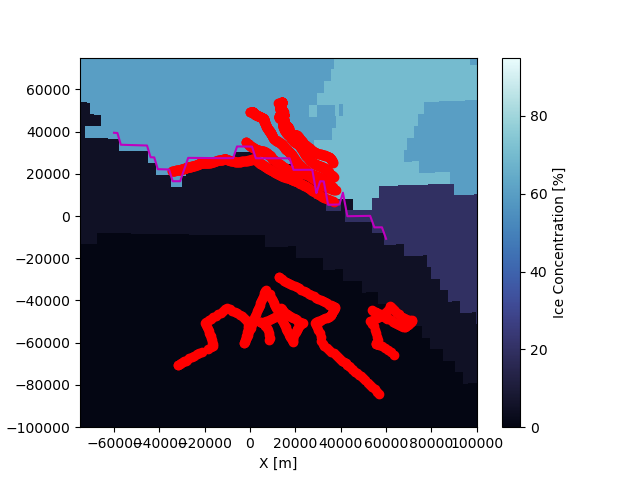

In [352]:
# Plot the Cartesian System
fig, ax = plt.subplots()
ax.plot(x_iceedge_interp, y_iceedge_interp, color='m')
im2 = ax.pcolormesh(x_icemap, y_icemap, ice_concentration,
                    cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im2)
cbar.set_label('Ice Concentration [%]')
ax.scatter(x_swifts_gliders, y_swifts_gliders, color='r')
ax.set_xlim(-75000, 100000)
ax.set_ylim(-100000, 75000)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

[   nan    nan    nan ... 71.175 71.175 71.175]
[-185.125 -185.075 -185.025 ... -135.225 -135.175 -135.125]


/opt/homebrew/Caskroom/mambaforge/base/envs/sassie-env/lib/python3.11/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/2269121137.py:6: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x, y = proj.transform(crs_wgs, cust, lon, lat)
/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_39668/1620886599.py:42: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply ex

Text(0, 0.5, 'Y [m]')

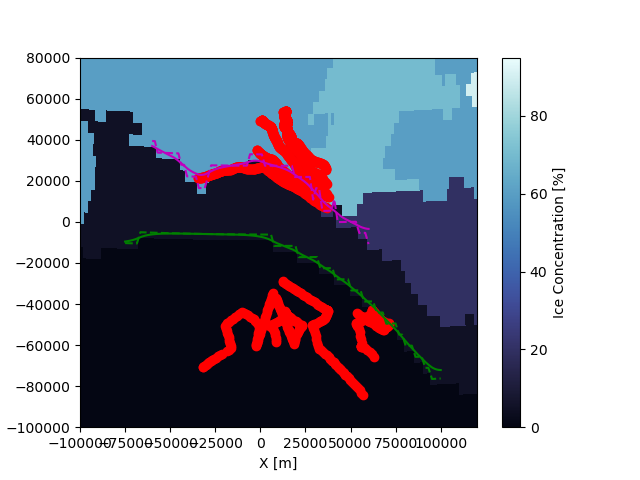

In [370]:
# Investigate other contours than the 15% contour
ice_conc_value = 1
ice_conc_variable = np.zeros(ice_concentration.shape)
ice_conc_variable[ice_concentration >= ice_conc_value] = 1
ice_edge_variable_contour_lon_vals = ice_map_lon[:,0]
lat_vals = ice_map_lat[0,:]
ice_edge_variable_contour_lat_vals = []

for n in range(ice_conc_variable.shape[0]):
    ice_edge_variable_lat_index_array = np.where(ice_conc_variable[n,:] == 1)[0]
    if ice_edge_variable_lat_index_array.size > 0:
        ice_edge_variable_contour_lat_vals.append(lat_vals[ice_edge_variable_lat_index_array[0]])
    else:
        ice_edge_variable_contour_lat_vals.append(np.NaN)

# Convert lon values to numpy array
ice_edge_variable_contour_lat_vals = np.array(ice_edge_variable_contour_lat_vals)
print(ice_edge_variable_contour_lat_vals)
print(ice_edge_variable_contour_lon_vals)

# Convert the ice edge values to cartesian and polar coordinates
x_variable_iceedge, y_variable_iceedge = latlon_to_local(ice_edge_variable_contour_lat_vals, ice_edge_variable_contour_lon_vals, lat_0, lon_0)

# Interpolate the x and y ice edge values to make a smooth curve of the ice edge
x_variable_iceedge_interp = np.linspace(-75000, 100000, num=50000)
y_variable_iceedge_interp = np.interp(x_variable_iceedge_interp, x_variable_iceedge, y_variable_iceedge)

fs = 1 / (x_variable_iceedge_interp[1] - x_variable_iceedge_interp[0])
cutoff = 1/40000
order = 1
nyq = 0.5 * fs
normal_cutoff = cutoff / nyq
b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
y_variable_iceedge_smoothed = signal.filtfilt(b, a, y_variable_iceedge_interp)

# Plot the Cartesian System
fig, ax = plt.subplots()
ax.plot(x_iceedge_interp, y_iceedge_smoothed, color='m')
ax.plot(x_variable_iceedge_interp, y_variable_iceedge_smoothed, color='g')
ax.plot(x_iceedge_interp, y_iceedge_interp, color='m', linestyle='dashed')
ax.plot(x_variable_iceedge_interp, y_variable_iceedge_interp, color='g', linestyle='dashed')
im2 = ax.pcolormesh(x_icemap, y_icemap, ice_concentration,
                    cmap=cmocean.cm.ice, zorder=0)
cbar = fig.colorbar(im2)
cbar.set_label('Ice Concentration [%]')
ax.scatter(x_swifts_gliders, y_swifts_gliders, color='r')
ax.set_xlim(-100000, 120000)
ax.set_ylim(-100000, 80000)
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')

In [371]:
distance_to_ice_edge_coordinate_swifts_gliders = distance_to_ice_edge(x_variable_iceedge_interp, y_variable_iceedge_smoothed, x_swifts_gliders, y_swifts_gliders)

Text(0, 0.5, 'Significant Wave Height [m]')

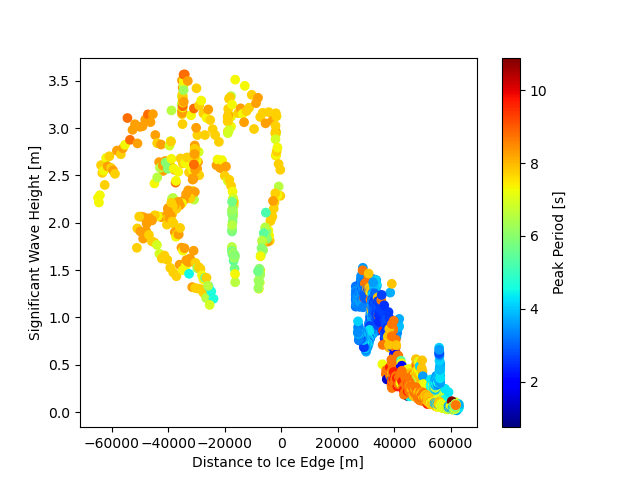

In [379]:
# Plot Significant Wave Height in the New Ice Distance Coordinate System
fig, ax = plt.subplots()
im = ax.scatter(distance_to_ice_edge_coordinate_swifts_gliders, df_with_gliders['hs'], c=df_with_gliders['wave_period'], cmap='jet')
cbar = fig.colorbar(im)
cbar.set_label('Peak Period [s]')
ax.set_xlabel('Distance to Ice Edge [m]')
ax.set_ylabel('Significant Wave Height [m]')

Text(0, 0.5, 'Significant Wave Height [m]')

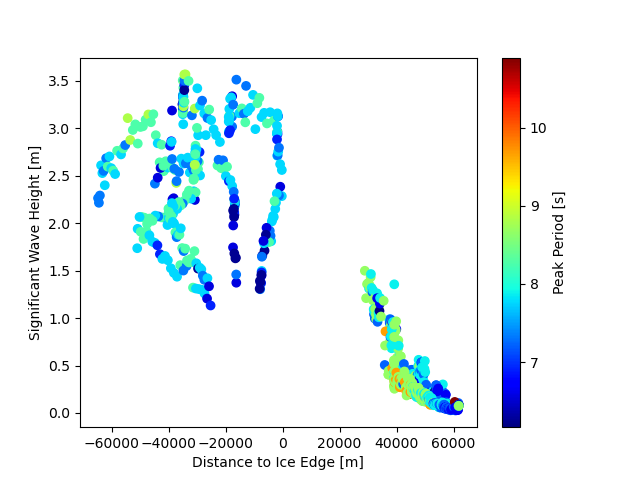

In [386]:
# Make a bonus pandas dataframe to sort out the wave period 
df_with_distance_to_ice = df_with_gliders.copy()
df_with_distance_to_ice['distance_to_ice'] = distance_to_ice_edge_coordinate_swifts_gliders

df_swell_only = df_with_distance_to_ice[df_with_distance_to_ice['wave_period'] > 6]

fig, ax = plt.subplots()
im = ax.scatter(df_swell_only['distance_to_ice'], df_swell_only['hs'], c=df_swell_only['wave_period'], cmap='jet')
cbar = fig.colorbar(im)
cbar.set_label('Peak Period [s]')
ax.set_xlabel('Distance to Ice Edge [m]')
ax.set_ylabel('Significant Wave Height [m]')

In [ ]:
# Create Orthogonal Projection of the ice edge to 